<a href="https://colab.research.google.com/github/sajacaros/bootcamp_colab/blob/main/%5BML_Project%5D_%EC%A0%84%EB%A0%A5%EC%82%AC%EC%9A%A9%EB%9F%89_%EC%98%88%EC%B8%A1_AI_%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Machine Learning 프로젝트 수행을 위한 코드 구조화

- ML project를 위해서 사용하는 템플릿 코드를 만듭니다.

1. **필요한 라이브러리와 데이터를 불러옵니다.**


2. **EDA를 수행합니다.** 이 때 EDA의 목적은 풀어야하는 문제를 위해서 수행됩니다.


3. **전처리를 수행합니다.** 이 때 중요한건 **feature engineering**을 어떻게 하느냐 입니다.


4. **데이터 분할을 합니다.** 이 때 train data와 test data 간의 분포 차이가 없는지 확인합니다.


5. **학습을 진행합니다.** 어떤 모델을 사용하여 학습할지 정합니다. 성능이 잘 나오는 GBM을 추천합니다.


6. **hyper-parameter tuning을 수행합니다.** 원하는 목표 성능이 나올 때 까지 진행합니다. 검증 단계를 통해 지속적으로 **overfitting이 되지 않게 주의**하세요.


7. **최종 테스트를 진행합니다.** 데이터 분석 대회 포맷에 맞는 submission 파일을 만들어서 성능을 확인해보세요.

## 1. 라이브러리, 데이터 불러오기

In [ ]:
# 설치에 필요한 라이브러리들이 있다면 모두 적어둡니다. anaconda에 기본적으로 설치되지 않은 라이브러리들을 적어두세요.
!pip install lightgbm optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.5 MB/s eta 0:00:00


In [ ]:
# 데이터분석 4종 세트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 모델들, 성능 평가
# (저는 일반적으로 정형데이터로 머신러닝 분석할 때는 이 2개 모델은 그냥 돌려봅니다. 특히 RF가 테스트하기 좋습니다.)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from lightgbm.sklearn import LGBMClassifier, LGBMRegressor

# 상관관계 분석, VIF : 다중공선성 제거
from statsmodels.stats.outliers_influence import variance_inflation_factor

# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold
from functools import partial

# hyper-parameter tuning을 위한 라이브러리, optuna
import optuna

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# flag setting
feature_reducing = 'pca'  # or 'fi' or False

In [ ]:
# 데이터를 불러옵니다.
file_path = '/content/drive/MyDrive/Colab Notebooks/ai6th/data/energy_2023/'
train_df = pd.read_csv(file_path+'train.csv')
building_df = pd.read_csv(file_path+'building_info.csv')
test_df = pd.read_csv(file_path+'test.csv')
submission_df = pd.read_csv(file_path+'sample_submission.csv', index_col='num_date_time')

In [ ]:
print(train_df.shape, building_df.shape, test_df.shape, submission_df.shape)

(204000, 10) (100, 7) (16800, 7) (16800, 1)


## 2. EDA

- 데이터에서 찾아야 하는 기초적인 내용들을 확인합니다.


- class imbalance, target distribution, outlier, correlation을 확인합니다.

In [ ]:
## On your Own
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_date_time  204000 non-null  object 
 1   건물번호           204000 non-null  int64  
 2   일시             204000 non-null  object 
 3   기온(C)          204000 non-null  float64
 4   강수량(mm)        43931 non-null   float64
 5   풍속(m/s)        203981 non-null  float64
 6   습도(%)          203991 non-null  float64
 7   일조(hr)         128818 non-null  float64
 8   일사(MJ/m2)      116087 non-null  float64
 9   전력소비량(kWh)     204000 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 15.6+ MB


In [ ]:
building_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   건물번호          100 non-null    int64  
 1   건물유형          100 non-null    object 
 2   연면적(m2)       100 non-null    float64
 3   냉방면적(m2)      100 non-null    float64
 4   태양광용량(kW)     100 non-null    object 
 5   ESS저장용량(kWh)  100 non-null    object 
 6   PCS용량(kW)     100 non-null    object 
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ KB


In [ ]:
train_df = train_df.drop(columns=['일조(hr)', '일사(MJ/m2)'])

In [ ]:
train_df.columns = ['num_date_time', 'num', 'date_time', 'temperature', 'precipitation', 'windspeed', 'humidity', 'target']
test_df.columns = ['num_date_time', 'num', 'date_time', 'temperature', 'precipitation', 'windspeed', 'humidity']
# building_df.columns = []

<ipython-input-11-12df9c1095ab>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_df.corr(), annot=True, fmt='.3f')


<Axes: >

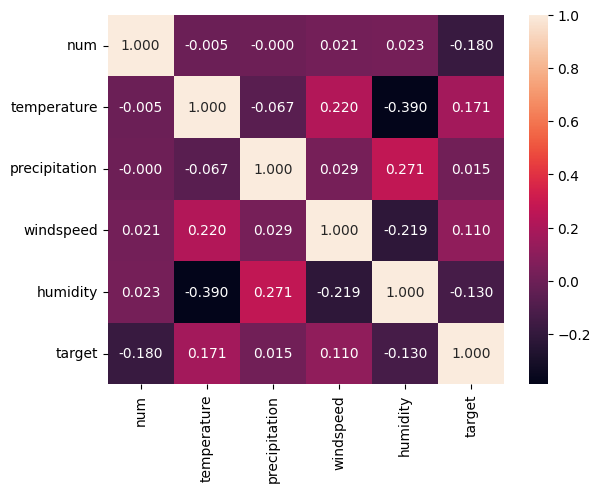

In [ ]:
# 상관관계 확인
sns.heatmap(train_df.corr(), annot=True, fmt='.3f')

<ipython-input-12-ca06d54dfd2b>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(test_df.corr(), annot=True, fmt='.3f')


<Axes: >

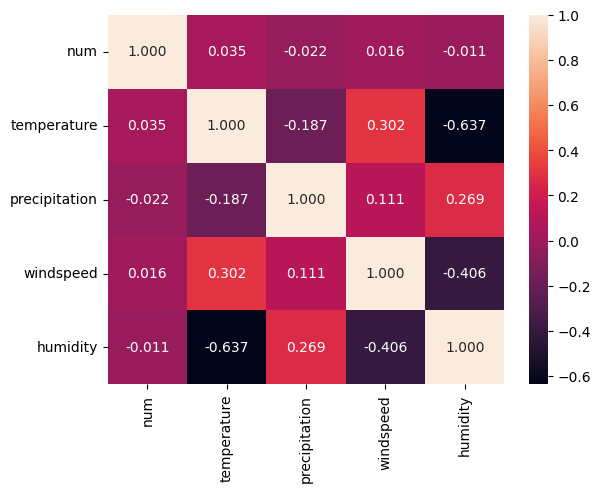

In [ ]:
sns.heatmap(test_df.corr(), annot=True, fmt='.3f')

In [ ]:
train_df.head(2)

,num_date_time,num,date_time,temperature,precipitation,windspeed,humidity,target
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,1047.36


In [ ]:
building_df.head(10)

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,건물기타,110634.00,39570.00,-,-,-
1,2,건물기타,122233.47,99000.00,-,-,-
2,3,건물기타,171243.00,113950.00,40,-,-
3,4,건물기타,74312.98,34419.62,60,-,-
4,5,건물기타,205884.00,150000.00,-,2557,1000
5,6,건물기타,205754.00,74565.00,-,-,-
6,7,건물기타,101711.52,41341.10,-,800,300
7,8,건물기타,75344.54,24117.00,-,-,-
8,9,건물기타,222882.35,15651.18,-,-,-
9,10,건물기타,31062.00,18637.00,-,-,-


In [ ]:
cond1 = (building_df['태양광용량(kW)'] == '-')
cond2 = (building_df['ESS저장용량(kWh)'] == '-')
cond3 = (building_df['PCS용량(kW)'] == '-')
building_df[cond1|cond2|cond3]

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,건물기타,110634.00,39570.00,-,-,-
1,2,건물기타,122233.47,99000.00,-,-,-
2,3,건물기타,171243.00,113950.00,40,-,-
3,4,건물기타,74312.98,34419.62,60,-,-
4,5,건물기타,205884.00,150000.00,-,2557,1000
...,...,...,...,...,...,...,...
95,96,호텔및리조트,93314.00,60500.00,-,-,-
96,97,호텔및리조트,55144.67,25880.00,-,-,-
97,98,호텔및리조트,53578.62,17373.75,-,-,-
98,99,호텔및리조트,53499.00,40636.00,-,-,-


In [ ]:
building_df.loc[cond1, '태양광용량(kW)'] = 0
building_df.loc[cond2, 'ESS저장용량(kWh)'] = 0
building_df.loc[cond3, 'PCS용량(kW)'] = 0
building_df['태양광용량(kW)'] = building_df['태양광용량(kW)'].astype(float)
building_df['ESS저장용량(kWh)'] = building_df['ESS저장용량(kWh)'].astype(float)
building_df['PCS용량(kW)'] = building_df['PCS용량(kW)'].astype(float)
building_df.columns = ['num', 'building_type', 'area1', 'area2', 'solar', 'ESS', 'PCS']
building_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   num            100 non-null    int64  
 1   building_type  100 non-null    object 
 2   area1          100 non-null    float64
 3   area2          100 non-null    float64
 4   solar          100 non-null    float64
 5   ESS            100 non-null    float64
 6   PCS            100 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 5.6+ KB


In [ ]:
train_df = pd.merge(train_df, building_df, on='num')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204000 entries, 0 to 203999
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_date_time  204000 non-null  object 
 1   num            204000 non-null  int64  
 2   date_time      204000 non-null  object 
 3   temperature    204000 non-null  float64
 4   precipitation  43931 non-null   float64
 5   windspeed      203981 non-null  float64
 6   humidity       203991 non-null  float64
 7   target         204000 non-null  float64
 8   building_type  204000 non-null  object 
 9   area1          204000 non-null  float64
 10  area2          204000 non-null  float64
 11  solar          204000 non-null  float64
 12  ESS            204000 non-null  float64
 13  PCS            204000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 23.3+ MB


In [ ]:
pd.pivot_table(data=train_df, index='building_type', values='target')

,target
building_type,
건물기타,1971.725375
공공,1683.978456
대학교,5458.636005
데이터센터,5396.897682
백화점및아울렛,2263.871801
병원,2912.790081
상용,2299.375129
아파트,1309.000627
연구소,2808.760916


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47932 (\N{HANGUL SYLLABLE MUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/

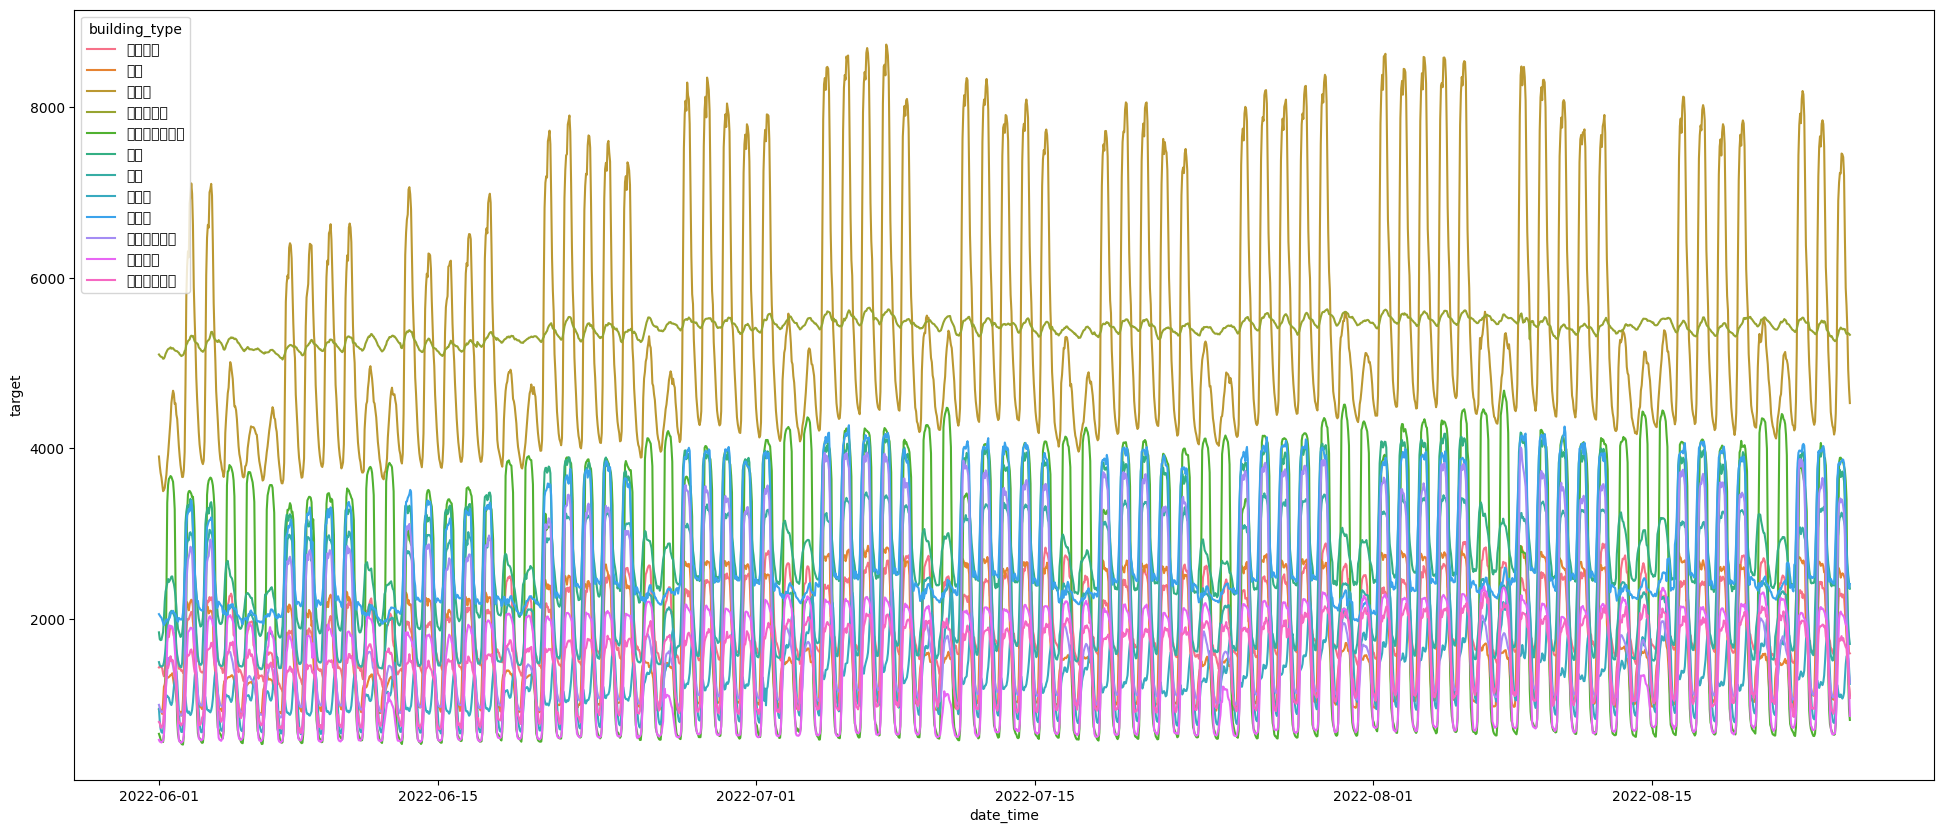

In [ ]:
train_df.date_time = pd.to_datetime(train_df.date_time)
plt.figure(figsize=(24, 10))
sns.lineplot(data=train_df, x='date_time', y='target', hue='building_type', errorbar=None)
plt.show()

이런 식으로 여러가지 그래프를 그려가며, 데이터에 대한 인사이트를 얻습니다!

### 3. 전처리

#### 결측치 처리

In [ ]:
# 결측치가 있는 column
train_df.precipitation = train_df.precipitation.fillna(0)
train_df.windspeed = train_df.windspeed.interpolate()
train_df.humidity = train_df.windspeed.interpolate()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204000 entries, 0 to 203999
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   num_date_time  204000 non-null  object        
 1   num            204000 non-null  int64         
 2   date_time      204000 non-null  datetime64[ns]
 3   temperature    204000 non-null  float64       
 4   precipitation  204000 non-null  float64       
 5   windspeed      204000 non-null  float64       
 6   humidity       204000 non-null  float64       
 7   target         204000 non-null  float64       
 8   building_type  204000 non-null  object        
 9   area1          204000 non-null  float64       
 10  area2          204000 non-null  float64       
 11  solar          204000 non-null  float64       
 12  ESS            204000 non-null  float64       
 13  PCS            204000 non-null  float64       
dtypes: datetime64[ns](1), float64(10), int64(1), object(

In [ ]:
# 각 feature들이 discretes한지 continuous한지 확인합니다.
train_df = pd.get_dummies(data=train_df, columns=['building_type'])
train_df.head()

,num_date_time,num,date_time,temperature,precipitation,windspeed,humidity,target,area1,area2,...,building_type_대학교,building_type_데이터센터,building_type_백화점및아울렛,building_type_병원,building_type_상용,building_type_아파트,building_type_연구소,building_type_지식산업센터,building_type_할인마트,building_type_호텔및리조트
0,1_20220601 00,1,2022-06-01 00:00:00,18.6,0.0,0.9,0.9,1085.28,110634.0,39570.0,...,0,0,0,0,0,0,0,0,0,0
1,1_20220601 01,1,2022-06-01 01:00:00,18.0,0.0,1.1,1.1,1047.36,110634.0,39570.0,...,0,0,0,0,0,0,0,0,0,0
2,1_20220601 02,1,2022-06-01 02:00:00,17.7,0.0,1.5,1.5,974.88,110634.0,39570.0,...,0,0,0,0,0,0,0,0,0,0
3,1_20220601 03,1,2022-06-01 03:00:00,16.7,0.0,1.4,1.4,953.76,110634.0,39570.0,...,0,0,0,0,0,0,0,0,0,0
4,1_20220601 04,1,2022-06-01 04:00:00,18.4,0.0,2.8,2.8,986.40,110634.0,39570.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# 중복정보가 있는 column 제거하기 위해 상관계수를 확인해봅니다.
# correlated_features =

#### 다중공선성 처리

In [ ]:
# VIF(Variance Inflation Factor)를 이용하여 다중공선성(서로 상관이 높은) column들을 제거합니다.
# VIF가 1이라면, 다른 feature와 전혀 상관관계가 없고 그 때의 R^2는 0입니다.


In [ ]:
# VIF가 threshold를 넘기는 feature들을 제거합니다.
# threshold =


### 4. 학습 데이터 분할

In [ ]:
# 첫번째 테스트용으로 사용하고, 실제 학습시에는 K-Fold CV를 사용합니다.
from sklearn.model_selection import train_test_split

X = train_df.drop(columns=['target', 'num_date_time', 'date_time'])
y = train_df['target']

# for OOF-prediction split 5% of data as validation dataset.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=42)


In [ ]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(193800, 22) (193800,) (10200, 22) (10200,)


#### feature extraction

- 차원의 저주를 해결하거나, 데이터의 feature 조합을 이용하는 새로운 feature를 생성할 때, PCA를 사용합니다.

- 분석에 사용할 feature를 선택하는 과정도 포함합니다.

In [ ]:
# PCA 적용
# if feature_reducing:
#     from sklearn.decomposition import PCA
#     pca = PCA(
#         n_components=0.90,  # 25 features, 원본 데이터의 분산을 90%까지 보존할 수 있는 축까지 사용하겠다.
#         whiten=True, # standardization
#         random_state=42
#     )

#     pca_df = pd.DataFrame(data=pca.fit_transform(X_train), columns=[f'PC{i}' for i in range(1, X_train.shape[1])])
#     display(pca_df)

### 5. 학습 및 평가

In [ ]:
def smape(y_true, y_pred):
    v = 2 * abs(y_pred - y_true) / (abs(y_pred) + abs(y_true))
    output = np.mean(v) * 100
    return output

In [ ]:
# 간단하게 LightGBM 테스트
# 적당한 hyper-parameter 조합을 두었습니다. (항상 best는 아닙니다. 예시입니다.)

param_grid = {
    "max_bin" : 20,
    "learning_rate" : 0.0025,
    "objective" : "regression",
    "boosting_type" : "gbdt",
    "metric" : "mae",
    "sub_feature" : 0.345,
    "bagging_fraction" : 0.85,
    "bagging_freq" : 40,
    "num_leaves" : 512,
    "min_data" : 500,
    "min_hessian" : 0.05,
    "verbose" : 1,
    "feature_fraction_seed" : 2,
    "bagging_seed" : 3
}

model = LGBMRegressor(**param_grid)

In [ ]:
print("\nFitting LightGBM...")
model.fit(X_train, y_train)


Fitting LightGBM...
[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, will be overridden by min_hessian=0.05. Current value: min_sum_hessian_in_leaf=0.05
[LightGBM] [Warning] feature_fraction is set with sub_feature=0.345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.345
[LightGBM] [Warning] min_data_in_leaf is set with min_data=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=40, subsample_freq=0 will be ignored. Current value: bagging_freq=40
[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, will be overridden by min_hessian=0.05. Current value: min_sum_hessian_in_leaf=0.05
[LightGBM] [Warning] feature_fraction is set with sub_feature=0.345, colsample_bytree=1.0 will be ignored. Current value: feature_fractio

LGBMRegressor(bagging_fraction=0.85, bagging_freq=40, bagging_seed=3,
              feature_fraction_seed=2, learning_rate=0.0025, max_bin=20,
              metric='mae', min_data=500, min_hessian=0.05, num_leaves=512,
              objective='regression', sub_feature=0.345, verbose=1)

In [ ]:
# metric은 그때마다 맞게 바꿔줘야 합니다.
evaluation_metric = smape

In [ ]:
print("Prediction")
pred_train = model.predict(X_train)
pred_val = model.predict(X_val)


train_score = evaluation_metric(y_train, pred_train)
val_score = evaluation_metric(y_val, pred_val)

print("Train Score : %.4f" % train_score)
print("Test Score : %.4f" % val_score)

Prediction
[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, will be overridden by min_hessian=0.05. Current value: min_sum_hessian_in_leaf=0.05
[LightGBM] [Warning] feature_fraction is set with sub_feature=0.345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.345
[LightGBM] [Warning] min_data_in_leaf is set with min_data=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=40, subsample_freq=0 will be ignored. Current value: bagging_freq=40
[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, will be overridden by min_hessian=0.05. Current value: min_sum_hessian_in_leaf=0.05
[LightGBM] [Warning] feature_fraction is set with sub_feature=0.345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.345
[L

### 6. Hyper-parameter Tuning

> GridSearchCV

** LightGBM의 hyperparameter **

[Official Documentation] https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

[Blog 1] https://smecsm.tistory.com/133

[Blog 2] https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5

[Blog 3] https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning/

In [ ]:
# GridSearchCV를 이용하여 가장 좋은 성능을 가지는 모델을 찾아봅시다. (이것은 첫번째엔 선택입니다.)
# Lightgbm은 hyper-parameter의 영향을 많이 받기 때문에, 저는 보통 맨처음에 한번 정도는 가볍게 GCV를 해봅니다.
# 성능 향상이 별로 없다면, lightgbm으로 돌린 대략적인 성능이 이 정도라고 생각하면 됩니다.
# 만약 성능 향상이 크다면, 지금 데이터는 hyper-parameter tuning을 빡빡하게 하면 성능 향상이 많이 이끌어 낼 수 있습니다.

from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth" : [8, 16, None],
    "n_estimators" : [100, 300, 500],
    "max_bin" : [20],
    "learning_rate" : [0.001, 0.0025, 0.003],
    "objective" : ["regression"],
    "boosting_type" : ["gbdt"],
    "metric" : ["mae"],
    "sub_feature" : [0.345],
    "bagging_fraction" : [0.7, 0.75, 0.85],
    "bagging_freq" : [40],
    "num_leaves" : [256, 512],
    "min_data" : [500],
    "verbose" : [-1], # 필수
    "min_hessian" : [0.05],
    "feature_fraction_seed" : [2],
    "bagging_seed" : [3]
}


gcv = GridSearchCV(estimator=model, param_grid=param_grid, cv=5,
                  n_jobs=-1, verbose=1)

gcv.fit(X_train, y_train)
print("Best Estimator : ", gcv.best_estimator_)

Best Estimator :  LGBMRegressor(bagging_fraction=0.85, bagging_freq=40, bagging_seed=3,
              feature_fraction_seed=2, learning_rate=0.003, max_bin=20,
              max_depth=None, metric='mae', min_data=500, min_hessian=0.05,
              n_estimators=500, num_leaves=256, objective='regression',
              sub_feature=0.345, verbose=-1)


In [ ]:
print("Prediction with Best Estimator")
gcv_pred_train = gcv.predict(X_train)
gcv_pred_val = gcv.predict(X_val)

gcv_train_score = evaluation_metric(y_train, gcv_pred_train)
gcv_val_score = evaluation_metric(y_val, gcv_pred_val)

print("Train MAE Score : %.4f" % gcv_train_score)
print("Test MAE Score : %.4f" % gcv_val_score)

Prediction with Best Estimator
Train MAE Score : 37.4341
Test MAE Score : 38.2622


In [ ]:
print("Performance Gain") # 이걸로 성능 향상 확인.
# print("in train : ", (##))
# print("in test : ", (##))

SyntaxError: ignored

> optuna를 사용해봅시다 !

In [ ]:
def optimizer(trial, X, y, K):
    # 조절할 hyper-parameter 조합을 적어줍니다.
    num_leaves = trial.suggest_categorical('num_leaves', [128, 256, 512])
    max_depth = trial.suggest_int('max_depth', 10, 15)  # low, high
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3) # low, high


    # 원하는 모델을 지정합니다, optuna는 시간이 오래걸리기 때문에 저는 보통 RF로 일단 테스트를 해본 뒤에 LGBM을 사용합니다.
    model = LGBMRegressor(
        num_leaves=num_leaves,
        max_depth=max_depth,
        learning_rate=learning_rate,
        random_state=42,
        verbose=-1
    )


    # K-Fold Cross validation을 구현합니다.
    folds = KFold(n_splits=K)
    losses = []

    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]

        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        loss = evaluation_metric(y_val, preds)
        losses.append(loss)


    # K-Fold의 평균 loss값을 돌려줍니다.
    return np.mean(losses)

In [ ]:
K = 5  # Kfold 수
opt_func = partial(optimizer, X=X_train, y=y_train, K=K)

study = optuna.create_study(direction="minimize") # 최소/최대 어느 방향의 최적값을 구할 건지.
study.optimize(opt_func, n_trials=5)

[I 2023-10-06 08:09:04,021] A new study created in memory with name: no-name-9fbbc000-6d4a-4ba0-b514-0ddfa7fc70dd
[I 2023-10-06 08:09:22,788] Trial 0 finished with value: 23.195231503210884 and parameters: {'num_leaves': 512, 'max_depth': 14, 'learning_rate': 0.2343125425969452}. Best is trial 0 with value: 23.195231503210884.
[I 2023-10-06 08:09:38,083] Trial 1 finished with value: 23.287082128024373 and parameters: {'num_leaves': 256, 'max_depth': 14, 'learning_rate': 0.23936684136497596}. Best is trial 0 with value: 23.195231503210884.
[I 2023-10-06 08:10:01,404] Trial 2 finished with value: 23.180766839540023 and parameters: {'num_leaves': 512, 'max_depth': 15, 'learning_rate': 0.15711979330297735}. Best is trial 2 with value: 23.180766839540023.
[I 2023-10-06 08:10:18,682] Trial 3 finished with value: 24.383786348610272 and parameters: {'num_leaves': 256, 'max_depth': 11, 'learning_rate': 0.06215168108258967}. Best is trial 2 with value: 23.180766839540023.
[I 2023-10-06 08:10:33,

In [ ]:
# optuna가 시도했던 모든 실험 관련 데이터
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_learning_rate,params_max_depth,params_num_leaves,state
0,0,23.195232,2023-10-06 08:09:04.029022,2023-10-06 08:09:22.788518,0 days 00:00:18.759496,0.234313,14,512,COMPLETE
1,1,23.287082,2023-10-06 08:09:22.793687,2023-10-06 08:09:38.083048,0 days 00:00:15.289361,0.239367,14,256,COMPLETE
2,2,23.180767,2023-10-06 08:09:38.086048,2023-10-06 08:10:01.403812,0 days 00:00:23.317764,0.157120,15,512,COMPLETE
3,3,24.383786,2023-10-06 08:10:01.411147,2023-10-06 08:10:18.682534,0 days 00:00:17.271387,0.062152,11,256,COMPLETE
4,4,23.353389,2023-10-06 08:10:18.684512,2023-10-06 08:10:33.294247,0 days 00:00:14.609735,0.291238,14,256,COMPLETE


In [ ]:
print("Best Score: %.4f" % study.best_value) # best score 출력
print("Best params: ", study.best_trial.params) # best score일 때의 하이퍼파라미터들

Best Score: 23.1808
Best params:  {'num_leaves': 512, 'max_depth': 15, 'learning_rate': 0.15711979330297735}


In [ ]:
# 실험 기록 시각화
optuna.visualization.plot_optimization_history(study)

In [ ]:
# hyper-parameter들의 중요도
optuna.visualization.plot_param_importances(study)

### 7. 테스트 및 제출 파일 생성

In [ ]:
## X_test 만들기
X_test =


In [ ]:
best_params = study.best_trial.params

best_model = RandomForestRegressor(**best_params)

best_model.fit(X_train, y_train)
preds = best_model.predict(X_test)
preds

In [ ]:
X_test # 원본 데이터랑 id가 맞는지 확인 해보기!

In [ ]:
submission = pd.read_csv('./data/sample_submission.csv')
submission

In [ ]:
submission.to_csv("submission.csv", index=False)